<a href="https://colab.research.google.com/github/SzymonNowakowski/Machine-Learning-2024/blob/master/Lab06_tree-methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 6 - Tree-based Methods

### Author: Szymon Nowakowski


# Introduction
-------------------

In today's class, we will explore **Classification and Regression Trees (CART)** and the **Random Forest** algorithm, both of which represent **tree-based methods** in machine learning. **CART** serves as a foundational algorithm capable of handling both **classification** and **regression** tasks. It works by recursively partitioning the data based on the most informative features, resulting in a simple yet powerful binary decision tree. Using measures like **Gini impurity** for classification and **mean squared error** for regression, **CART** selects the best splits to optimize predictive accuracy.

While individual decision trees are easy to interpret, they can suffer from **overfitting**, limiting their generalization to new data. This challenge is effectively addressed by **Random Forest**, an **ensemble method** that constructs multiple decision trees on random subsets of the data and aggregates their predictions. By averaging results in regression tasks or using majority voting in classification, **Random Forest** significantly improves accuracy and robustness while reducing overfitting.

Both **CART** and **Random Forest** are considered **off-the-shelf** methods, meaning they can be applied directly to a wide range of problems with minimal tuning, making them go-to solutions for many real-world machine learning tasks. Today, we will implement these algorithms, apply them to datasets, and evaluate their performance to better understand their practical applications.

# CART: Detailed Explanation
----------------------------

## The Split into Regions in Decision Trees

In both **classification** and **regression trees**, the data space is recursively partitioned into rectangular regions based on feature values. At each node of the tree, the algorithm selects a **feature** and a **threshold** that best splits the data into two subsets. This process continues recursively, resulting in a hierarchical partitioning of the feature space.

- Each split corresponds to a decision rule, like $X_j < t$, where $X_j$ is a feature and $t$ is the threshold.
- The data points that satisfy the rule go to the left branch; the rest go to the right.
- The process continues until a stopping criterion is met (e.g., maximum depth, minimum number of samples, or impurity threshold).

The end result is a division of the space into **non-overlapping regions** $R_1, R_2, \dots, R_M$, where each region corresponds to a terminal (leaf) node in the tree.




## How the Regression Tree Predicts a New Value

In a **regression tree**, the prediction for a new observation is based on the **mean** of the target values in the region where the observation falls.

- When a new data point is passed through the tree, it follows the decision rules from the root to a specific leaf node.
- The predicted value is the **average** of the training data points within that leaf's region.

**Mathematically:**

If a region $R_m$ contains data points $\{y_i\}_{i=1}^{N_m}$, the prediction $\hat{y}$ for any $x \in R_m$ is:

$$
\hat{y} = \frac{1}{N_m} \sum_{i: x_i \in R_m} y_i
$$

## How the Regression Tree Builds the Region Partitioning

The goal in regression is to minimize the **sum of squared residuals (SSR)** within each region. At each split, the algorithm selects:

- The **feature** $X_j$ to split on.
- The corresponding **threshold** $t$ for that feature.

**The selection process involves both $X_j$ (the feature) and $t$ (the split point).**

The algorithm proceeds as follows:

1. **For each feature** $X_j$:
   - Consider all possible thresholds $t$ (often midpoints between sorted unique values).
   - Evaluate the SSR for each possible split.

2. **Select the feature $X_j^*$ and threshold $t^*$** that maximize the total RSS gain:

  $$
  (X_j^*, t^*) = \arg\max_{X_j, t} \left\{ \underbrace{\sum_{i: x_i \in \text{Parent}} (y_i - \bar{y})^2}_{\text{Parent RSS}} - \underbrace{\sum_{m=1}^{2} \sum_{i: x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2}_{\text{Sum of Children RSS (after split on } X_j \text{ at } t)} \right\}
  $$

  Where:

  - $R_m(X_j, t)$ is a region (leaf node) defined by the split on feature $X_j$ at threshold $t$.
  - $\bar{y}$ is the mean target value in the parent region.
  - $\bar{y}_{R_m}$ is the mean target value in region $R_m(X_j, t)$.


  This process is repeated recursively for each new subset until a stopping criterion is met.

## Question

Do we really need to consider all possible values $t$ for the split? How can we attempt to optimize the selection process?

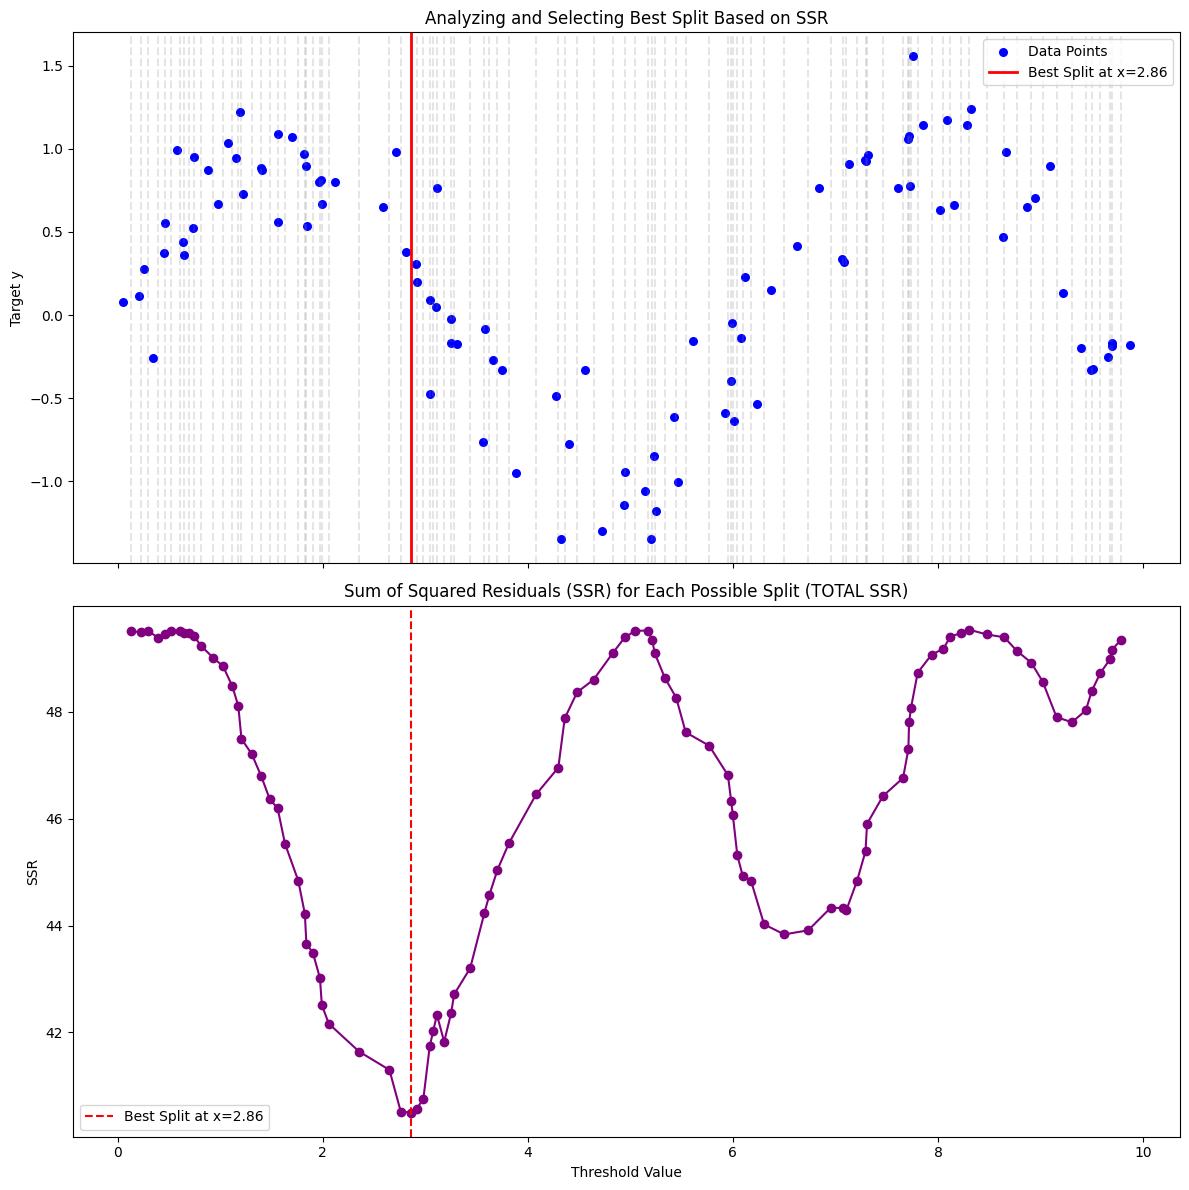

Best split at x = 2.86 with TOTAL SSR = 40.50


In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Generate synthetic data
np.random.seed(42)
X = np.sort(np.random.rand(100) * 10)  # 1D array for simplicity
y = np.sin(X) + np.random.normal(0, 0.3, size=X.shape[0])  # Noisy sine wave

# Step 2: Analyze possible splits and compute SSR
def compute_ssr(y):
    mean_y = np.mean(y)
    return np.sum((y - mean_y) ** 2)

best_ssr = float('inf')
best_split = None
ssr_list = []

# Consider splits between adjacent sorted X values
for i in range(1, len(X)):
    threshold = (X[i - 1] + X[i]) / 2

    # Split data using boolean masks
    left_mask = X < threshold
    right_mask = X >= threshold

    # Calculate SSR for each region
    ssr_left = compute_ssr(y[left_mask])
    ssr_right = compute_ssr(y[right_mask])
    total_ssr = ssr_left + ssr_right

    ssr_list.append((threshold, total_ssr))

    # Keep track of the best split
    if total_ssr < best_ssr:
        best_ssr = total_ssr
        best_split = threshold

# Visualize the data, splits, and the best split along with SSR values
fig, axes = plt.subplots(2, 1, figsize=(12, 12), sharex=True)  # Two vertically aligned subplots

# First subplot: Original data with split lines
axes[0].scatter(X, y, color='blue', label='Data Points', s=30)

for threshold, ssr in ssr_list:
    axes[0].axvline(x=threshold, color='gray', linestyle='--', alpha=0.2)

axes[0].axvline(x=best_split, color='red', linestyle='-', linewidth=2, label=f'Best Split at x={best_split:.2f}')
axes[0].set_title('Analyzing and Selecting Best Split Based on SSR')
axes[0].set_ylabel('Target y')
axes[0].legend()

# Second subplot: SSR values for each split
thresholds, ssrs = zip(*ssr_list)
axes[1].plot(thresholds, ssrs, marker='o', color='purple')
axes[1].axvline(x=best_split, color='red', linestyle='--', label=f'Best Split at x={best_split:.2f}')
axes[1].set_title('Sum of Squared Residuals (SSR) for Each Possible Split (TOTAL SSR)')
axes[1].set_xlabel('Threshold Value')
axes[1].set_ylabel('SSR')
axes[1].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


print(f"Best split at x = {best_split:.2f} with TOTAL SSR = {best_ssr:.2f}")



## How the Classification Tree Predicts a Class for a New Observation

In a **classification tree**, the prediction for a new observation is based on the **majority class** within the region it falls into.

- The new observation follows the decision rules down the tree until it reaches a leaf node.
- The predicted class is the one with the highest proportion of samples in that leaf.

If region $R_m$ contains samples from classes $C_1, C_2, \dots, C_k$, the predicted class $\hat{C}$ is:

$$
\hat{C} = \arg\max_{c} \, P_c
$$

Where $P_c$ is the proportion of class $c$ in region $R_m$.


## How the Classification Tree Builds the Region Partitioning

In classification, the goal is to minimize impurity in the resulting regions. At each split, the algorithm selects:

- The **feature** $X_j$ to split on.
- The corresponding **threshold** $t$ for that feature.

**The selection process again involves both $X_j$ (the feature) and $t$ (the split point).**

The process is as follows:

1. **For each feature** $X_j$:
   - Consider all possible thresholds $t$.
   - Calculate impurity measures (Gini or Cross-Entropy) for the resulting splits.

2. **Select the feature $X_j^*$ and threshold $t^*$** that result in the **largest decrease in impurity**.

  a) Gini Index

    The **Gini Index** measures the probability of misclassification:

    $$
    G(R_m) = 1 - \sum_{c=1}^{K} p_{mc}^2
    $$

    and also
    
    $$
    G(R_m) = \sum_{c=1}^{K} p_{mc} - \sum_{c=1}^{K} p_{mc}^2 =  \sum_{c=1}^{K} p_{mc}(1-p_{mc})
    $$

    Where:

    - $p_{mc}$ is the proportion of samples of class $c$ in region $R_m$.

  b) Cross-Entropy (Deviance)

    The **Cross-Entropy** measure is:

    $$
    H(R_m) = - \sum_{c=1}^{K} p_{mc} \log(p_{mc})
    $$

The split that leads to the **greatest reduction in impurity** (using either Gini or Cross-Entropy) is selected.




## Gain Formula

The **Gini Gain** measures the reduction in impurity achieved by a split in a decision tree. It is calculated as follows:

$$
\text{Gain} = \text{Measure(parent)} - \left( \frac{N_L}{N} \cdot \text{Measure}(L) + \frac{N_R}{N} \cdot \text{Measure}(R) \right)
$$

Where:
- $\text{Measure}()$ stands for Gini $\text{G}()$ or Cross-Entropy $\text{H}()$
- $N$ = Total number of samples in the parent node
- $N_L$ = Number of samples in the left (or low) child node
- $N_R$ = Number of samples in the right (or top) child node
- $\text{Measure(parent)}$ measures impurity of the parent node
- $\text{Measure}(L)$ = measures impurity of the left (low) child
- $\text{Measure}(R)$ = measures impurity of the right (top) child

The split that results in the **highest Gain** is typically selected, as it leads to the most significant reduction in impurity.



## Gini index and Cross Entropy Charts

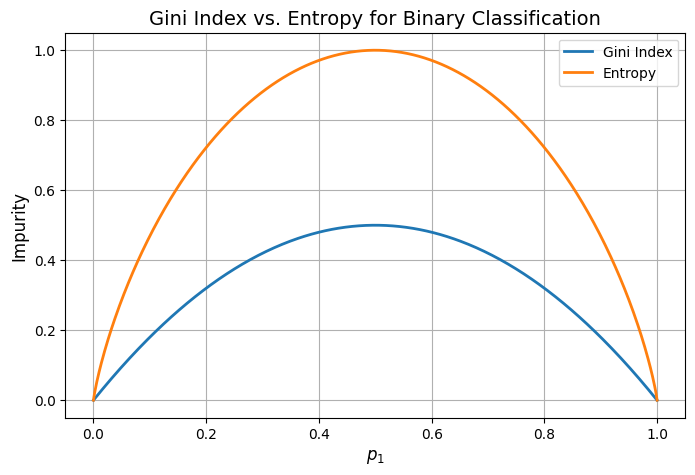

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Define probability values for class 1
p1 = np.linspace(0, 1, 500)
p2 = 1 - p1

# Gini index
gini = 1 - p1**2 - p2**2

# Entropy (handle log(0) by setting 0 * log(0) = 0)
epsilon = 1e-12  # to avoid log(0)
entropy = -(p1 * np.log2(p1 + epsilon) + p2 * np.log2(p2 + epsilon))

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(p1, gini, label='Gini Index', linewidth=2)
plt.plot(p1, entropy, label='Entropy', linewidth=2)
plt.xlabel('$p_1$', fontsize=12)
plt.ylabel('Impurity', fontsize=12)
plt.title('Gini Index vs. Entropy for Binary Classification', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()



## Key Points

- The **tree-building process selects both the feature** $X_j$ **and the threshold** $t$ **that optimally split the data** based on the chosen objective (SSR for regression, impurity reduction for classification).
- This process continues recursively, resulting in a tree that partitions the data space into regions with either low variance (for regression) or low impurity (for classification).


** FIRST SPLIT **
 - Parent Gini = 0.5000
 - Best gain = 0.4615
 - Weighted Child Gini = 0.0385
 => Feature 2, Threshold=-0.24


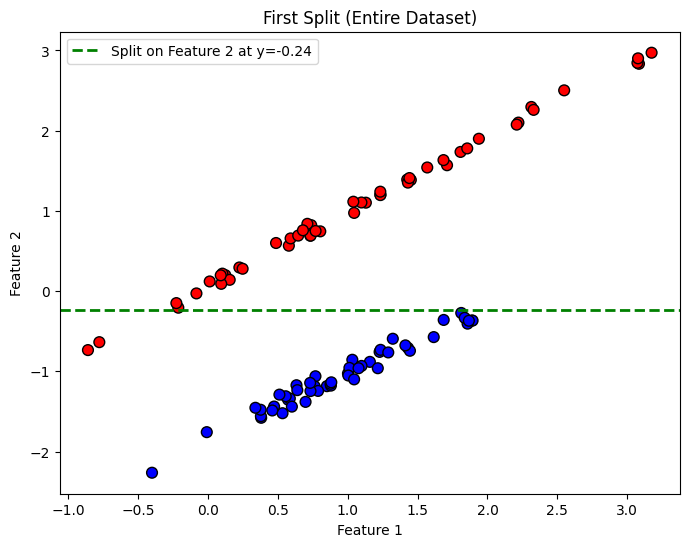

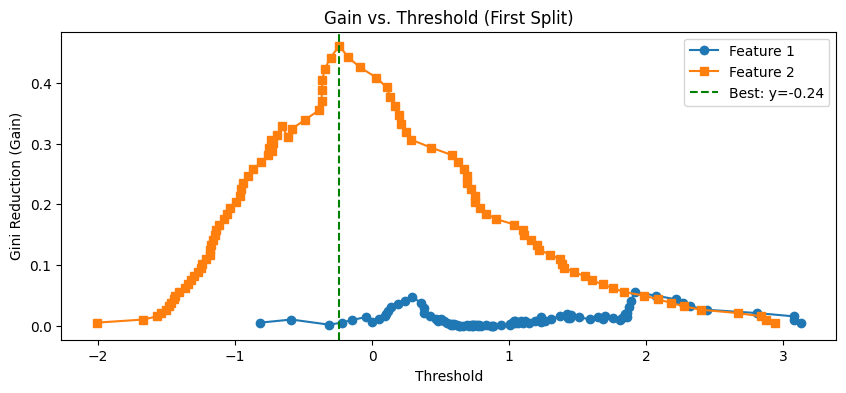

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

# -------------------------------------------------------------------
# 1) Generate the 2D Dataset
# -------------------------------------------------------------------
np.random.seed(42)
X, y = make_classification(
    n_samples=100,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    n_clusters_per_class=1,
    n_classes=2,
    random_state=42
)

# -------------------------------------------------------------------
# 2) Helper Functions
# -------------------------------------------------------------------
def compute_gini(y_subset):
    """
    Compute Gini impurity for a binary classification:
       Gini = 1 - (p0^2 + p1^2)
    """
    if len(y_subset) == 0:
        return 0.0
    p0 = np.mean(y_subset == 0)
    p1 = 1 - p0
    return 1.0 - (p0**2 + p1**2)

def find_best_split(X_data, y_data):
    """
    Finds the split that MAXIMIZES the 'gain' in Gini, i.e.:
        gain = Gini(parent) - [weighted Gini(children)]

    Returns:
      best_gain   : float   (the maximum reduction in Gini)
      best_split  : (feat_idx, threshold)
      all_splits  : list of (feat_idx, threshold, gain)
    """
    parent_gini = compute_gini(y_data)
    n_total = len(y_data)

    best_gain = -1.0
    best_split = None
    all_splits = []

    n_features = X_data.shape[1]

    for feat_idx in range(n_features):
        # Sort by this feature
        sort_idx = np.argsort(X_data[:, feat_idx])
        X_sorted = X_data[sort_idx]
        y_sorted = y_data[sort_idx]

        # Check thresholds between adjacent points
        for i in range(1, n_total):
            threshold = 0.5 * (X_sorted[i - 1, feat_idx] + X_sorted[i, feat_idx])

            left_mask = (X_data[:, feat_idx] < threshold)
            right_mask = ~left_mask

            gini_left = compute_gini(y_data[left_mask])
            gini_right = compute_gini(y_data[right_mask])

            # Weighted child Gini
            w_child_gini = (gini_left * np.sum(left_mask) +
                            gini_right * np.sum(right_mask)) / n_total

            gain = parent_gini - w_child_gini
            all_splits.append((feat_idx, threshold, gain))

            # Track the best split (max gain)
            if gain > best_gain:
                best_gain = gain
                best_split = (feat_idx, threshold)

    return best_gain, best_split, all_splits

def plot_data_with_split(X_data, y_data, feat_idx, threshold, title="Split"):
    """
    Plot ALL data points, draw a single split line (vertical or horizontal)
    across the entire plane.
    """
    plt.figure(figsize=(8,6))
    colors = ['blue' if c == 0 else 'red' for c in y_data]
    plt.scatter(X_data[:,0], X_data[:,1], c=colors, edgecolor='k', s=60)

    if feat_idx == 0:
        # vertical line
        plt.axvline(x=threshold, color='green', linestyle='--', linewidth=2,
                    label=f"Split on Feature 1 at x={threshold:.2f}")
    else:
        # horizontal line
        plt.axhline(y=threshold, color='green', linestyle='--', linewidth=2,
                    label=f"Split on Feature 2 at y={threshold:.2f}")

    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.show()

def plot_gain_vs_threshold(all_splits, best_feat, best_thresh, title="Gain vs. Threshold"):
    """
    Plot the gain for each threshold in each feature.
    We'll mark the best threshold for the best feature with a vertical line.
    """
    f1_thresholds = [t for (f,t,g) in all_splits if f == 0]
    f1_gains      = [g for (f,t,g) in all_splits if f == 0]
    f2_thresholds = [t for (f,t,g) in all_splits if f == 1]
    f2_gains      = [g for (f,t,g) in all_splits if f == 1]

    plt.figure(figsize=(10,4))
    plt.plot(f1_thresholds, f1_gains, 'o-', label='Feature 1')
    plt.plot(f2_thresholds, f2_gains, 's-', label='Feature 2')

    # Mark the best threshold
    if best_feat == 0:
        plt.axvline(best_thresh, color='green', linestyle='--',
                    label=f"Best: x={best_thresh:.2f}")
    else:
        plt.axvline(best_thresh, color='green', linestyle='--',
                    label=f"Best: y={best_thresh:.2f}")

    plt.title(title)
    plt.xlabel("Threshold")
    plt.ylabel("Gini Reduction (Gain)")
    plt.legend()
    plt.show()

# -------------------------------------------------------------------
# 3) Find & Visualize the FIRST Split
# -------------------------------------------------------------------
first_gain, (first_feat, first_thresh), first_splits = find_best_split(X, y)
parent_gini = compute_gini(y)
weighted_child_gini = parent_gini - first_gain

print("** FIRST SPLIT **")
print(f" - Parent Gini = {parent_gini:.4f}")
print(f" - Best gain = {first_gain:.4f}")
print(f" - Weighted Child Gini = {weighted_child_gini:.4f}")
print(f" => Feature {first_feat+1}, Threshold={first_thresh:.2f}")

# Visualize entire dataset + first split line
plot_data_with_split(X, y, first_feat, first_thresh, title="First Split (Entire Dataset)")

# (Optional) Plot gain vs. threshold curves
plot_gain_vs_threshold(first_splits, first_feat, first_thresh, title="Gain vs. Threshold (First Split)")


** FIRST SPLIT Recap **
 - Feature=2, threshold=-0.24
   -> Low subset size: 52
   -> Top subset size: 48

** Potential SECOND SPLIT in LOW subset **
 - Parent Gini (LOW) = 0.0740
 - Best gain (LOW)   = 0.0740
 - Weighted Child Gini = 0.0000
 => Feature 1, threshold=-0.59

** Potential SECOND SPLIT in TOP subset **
 - Parent Gini (TOP) = 0.0000
 - Best gain (TOP)   = 0.0000
 - Weighted Child Gini = 0.0000
 => Feature 1, threshold=-0.22


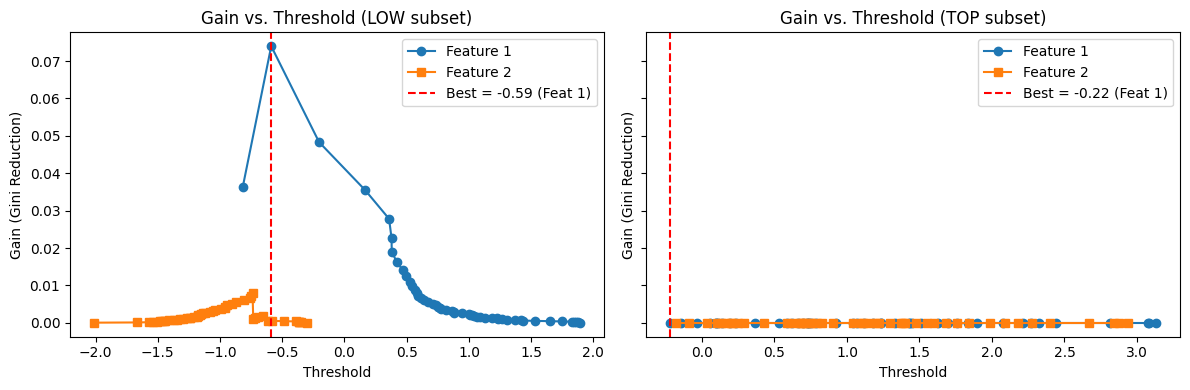


** CHOSEN Second Split = LOW subset **
 - Feature 1
 - Threshold = -0.59
 - Gain = 0.0740


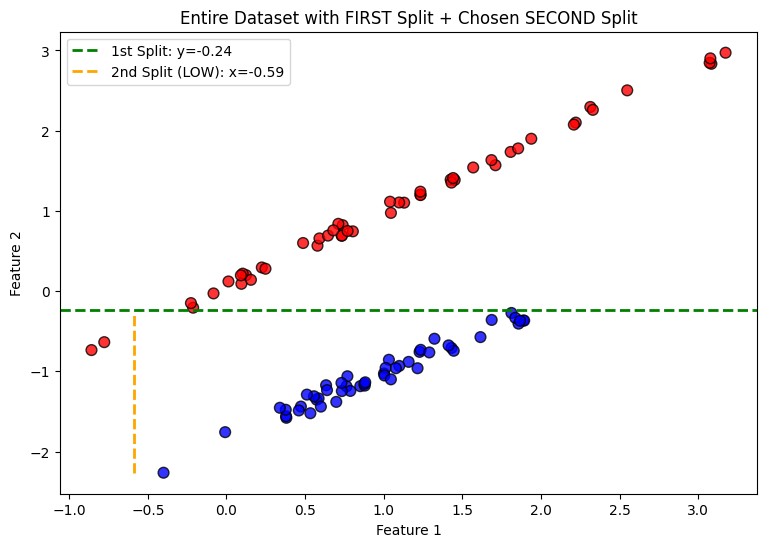

In [6]:
# We assume from Cell 1 we have:
#   X, y
#   first_feat, first_thresh      # The first split
#   find_best_split, compute_gini # Functions
#   plus any plotting utilities

import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------
# 1) Partition the data using the FIRST split
# ----------------------------------------------------
low_mask = (X[:, first_feat] < first_thresh)
top_mask = ~low_mask

X_low, y_low = X[low_mask], y[low_mask]
X_top, y_top = X[top_mask], y[top_mask]

print("** FIRST SPLIT Recap **")
print(f" - Feature={first_feat + 1}, threshold={first_thresh:.2f}")
print(f"   -> Low subset size: {len(y_low)}")
print(f"   -> Top subset size: {len(y_top)}")

# ----------------------------------------------------
# 2) Find a SECOND split in both the LOW and TOP subsets
#    (We measure Gini gain in each subset.)
# ----------------------------------------------------
low_gain, (low_feat, low_thresh), low_splits = find_best_split(X_low, y_low)
top_gain, (top_feat, top_thresh), top_splits = find_best_split(X_top, y_top)

low_parent_gini = compute_gini(y_low)
top_parent_gini = compute_gini(y_top)

print("\n** Potential SECOND SPLIT in LOW subset **")
print(f" - Parent Gini (LOW) = {low_parent_gini:.4f}")
print(f" - Best gain (LOW)   = {low_gain:.4f}")
print(f" - Weighted Child Gini = {low_parent_gini - low_gain:.4f}")
print(f" => Feature {low_feat + 1}, threshold={low_thresh:.2f}")

print("\n** Potential SECOND SPLIT in TOP subset **")
print(f" - Parent Gini (TOP) = {top_parent_gini:.4f}")
print(f" - Best gain (TOP)   = {top_gain:.4f}")
print(f" - Weighted Child Gini = {top_parent_gini - top_gain:.4f}")
print(f" => Feature {top_feat + 1}, threshold={top_thresh:.2f}")

# ----------------------------------------------------
# 3) Side-by-side Gains Plots for LOW and TOP subsets
# ----------------------------------------------------
def plot_gain_vs_threshold_subset(all_splits, best_f, best_t, title):
    """
    Plots the gain vs threshold for the two features in a given subset.
    We'll draw a vertical line at 'best_t' if best_f is that feature.
    """
    f1_thresh = [t for (f, t, g) in all_splits if f == 0]
    f1_gains  = [g for (f, t, g) in all_splits if f == 0]
    f2_thresh = [t for (f, t, g) in all_splits if f == 1]
    f2_gains  = [g for (f, t, g) in all_splits if f == 1]

    plt.plot(f1_thresh, f1_gains, 'o-', label='Feature 1')
    plt.plot(f2_thresh, f2_gains, 's-', label='Feature 2')

    # Mark the best threshold for the best feature
    if best_f == 0:
        plt.axvline(best_t, color='red', linestyle='--',
                    label=f"Best = {best_t:.2f} (Feat 1)")
    else:
        plt.axvline(best_t, color='red', linestyle='--',
                    label=f"Best = {best_t:.2f} (Feat 2)")

    plt.title(title)
    plt.xlabel("Threshold")
    plt.ylabel("Gain (Gini Reduction)")
    plt.legend()

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Plot for LOW subset
plt.sca(axes[0])
plot_gain_vs_threshold_subset(
    low_splits, low_feat, low_thresh,
    title="Gain vs. Threshold (LOW subset)"
)

# Plot for TOP subset
plt.sca(axes[1])
plot_gain_vs_threshold_subset(
    top_splits, top_feat, top_thresh,
    title="Gain vs. Threshold (TOP subset)"
)

plt.tight_layout()
plt.show()

# ----------------------------------------------------
# 4) Choose the best second split overall
# ----------------------------------------------------
# Compare the best gain in LOW vs. TOP
if low_gain > top_gain:
    chosen_side = "LOW"
    chosen_feat   = low_feat
    chosen_thresh = low_thresh
    chosen_gain   = low_gain
else:
    chosen_side = "TOP"
    chosen_feat   = top_feat
    chosen_thresh = top_thresh
    chosen_gain   = top_gain

print(f"\n** CHOSEN Second Split = {chosen_side} subset **")
print(f" - Feature {chosen_feat + 1}")
print(f" - Threshold = {chosen_thresh:.2f}")
print(f" - Gain = {chosen_gain:.4f}")

# ----------------------------------------------------
# 5) Visualize the ENTIRE dataset again with
#    (a) First split across entire plane
#    (b) ONLY the chosen second split line
# ----------------------------------------------------
plt.figure(figsize=(9,6))
colors = ["blue" if lbl == 0 else "red" for lbl in y]
plt.scatter(X[:,0], X[:,1], c=colors, edgecolor='k', s=60, alpha=0.8)

# (a) First split line across entire plane
if first_feat == 0:
    # vertical
    plt.axvline(first_thresh, color='green', linestyle='--', linewidth=2,
                label=f"1st Split: x={first_thresh:.2f}")
else:
    # horizontal
    plt.axhline(first_thresh, color='green', linestyle='--', linewidth=2,
                label=f"1st Split: y={first_thresh:.2f}")

# (b) The chosen second split line in its bounding box only
if chosen_side == "LOW":
    region_X, region_y = X_low, y_low
else:
    region_X, region_y = X_top, y_top

x_min, x_max = region_X[:,0].min(), region_X[:,0].max()
y_min, y_max = region_X[:,1].min(), region_X[:,1].max()

if chosen_feat == 0:
    # vertical line restricted to region's bounding box
    plt.plot(
        [chosen_thresh, chosen_thresh],
        [y_min, y_max],
        color='orange', linestyle='--', linewidth=2,
        label=f"2nd Split ({chosen_side}): x={chosen_thresh:.2f}"
    )
else:
    # horizontal line
    plt.plot(
        [x_min, x_max],
        [chosen_thresh, chosen_thresh],
        color='orange', linestyle='--', linewidth=2,
        label=f"2nd Split ({chosen_side}): y={chosen_thresh:.2f}"
    )

plt.title("Entire Dataset with FIRST Split + Chosen SECOND Split")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


# CART Tree Pruning

--------------

CART Tree can become too complex, leading to **overfitting**. To prevent this, we use **pruning**, which removes unnecessary branches while maintaining accuracy.

## Types of Pruning

1. **Pre-pruning (Early Stopping)** – Limits tree growth using parameters like `max_depth`, `min_samples_split`, etc.
2. **Post-pruning (Cost Complexity Pruning, CCP)** – Grows a full tree and then removes branches based on a trade-off between accuracy and complexity.

# Building CART on a Real Dataset
--------------------------------

## The Breast Cancer Data

We will use the Breast Cancer dataset from scikit-learn. This dataset has features computed from digitized images of a breast mass, and the label indicates *malignant* vs. *benign* tumors.

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import accuracy_score

# 1) Load the Breast Cancer dataset
data = load_breast_cancer()
X = data.data      # Features
y = data.target    # Target (0 = malignant, 1 = benign)

# 2) Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print("Training set size:", X_train.shape, "Test set size:", X_test.shape)

Training set size: (398, 30) Test set size: (171, 30)


## Growing a CART tree

We’ll train a `DecisionTreeClassifier` without specifying strong stopping criteria (e.g., `max_depth=None`). This yields a fully grown tree, which can be prone to **overfitting**.

In [8]:
# Build a "full" decision tree (no max_depth specified, so it can grow deep)
full_tree = DecisionTreeClassifier(
    criterion='gini',
    random_state=42
)
full_tree.fit(X_train, y_train)

# Evaluate training accuracy (likely very high)
y_train_pred_full = full_tree.predict(X_train)
y_test_pred_full  = full_tree.predict(X_test)
train_acc_full = accuracy_score(y_train, y_train_pred_full)
test_acc_full  = accuracy_score(y_test,  y_test_pred_full)

print("Full Tree - Train Accuracy:", train_acc_full)
print("Full Tree - Test Accuracy: ", test_acc_full)


Full Tree - Train Accuracy: 1.0
Full Tree - Test Accuracy:  0.9415204678362573


## Note overfitting in results above

As expected, the training accuracy is extremely high (=1.0). The test accuracy might be somewhat lower, indicating possible overfitting.

## Visualisation

Let’s visualize the tree structure.




=== Full Tree Rules ===
|--- mean concave points <= 0.05
|   |--- worst radius <= 16.83
|   |   |--- area error <= 48.70
|   |   |   |--- worst smoothness <= 0.18
|   |   |   |   |--- smoothness error <= 0.00
|   |   |   |   |   |--- worst texture <= 26.89
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- worst texture >  26.89
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- smoothness error >  0.00
|   |   |   |   |   |--- worst texture <= 33.35
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- worst texture >  33.35
|   |   |   |   |   |   |--- worst texture <= 34.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- worst texture >  34.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |--- worst smoothness >  0.18
|   |   |   |   |--- class: 0
|   |   |--- area error >  48.70
|   |   |   |--- concavity error <= 0.02
|   |   |   |   |--- class: 0
|   |   |   |--- concavity error >  0.02
|   |   |   |   |--- class: 1
|  

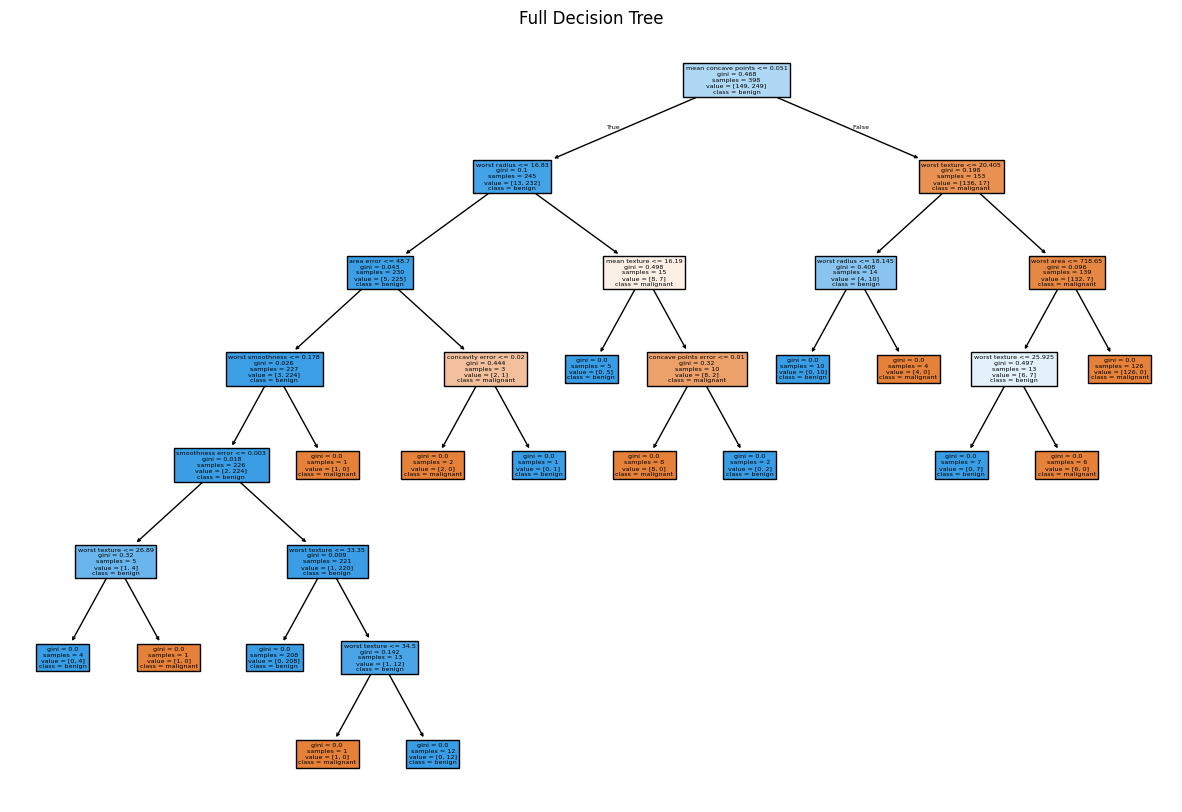

In [9]:
# 3a) Print textual description of the full tree
tree_rules = export_text(full_tree, feature_names=list(data.feature_names))
print("\n=== Full Tree Rules ===")
print(tree_rules[:1500], "...")  # Print partial, since it can be very large

# 3b) Plot the full tree (warning: can be big!)
plt.figure(figsize=(15, 10))
plot_tree(
    full_tree,
    feature_names=data.feature_names,
    class_names=["malignant","benign"],
    filled=True
)
plt.title("Full Decision Tree")
plt.show()

## Feature Importance Analysis

For regression, feature importance is based on the reduction in RSS (Residual Sum of Squares) in this feature throughout the tree:

$$
I(X_j) = \sum_{\text{splits on } X_j} (RSS_{\text{parent}} - RSS_L - RSS_R)
$$

where $RSS$ is the Residual Sum of Squares.

For classification, similarly, instead of RSS Gini index  or Cross Entropy is used.

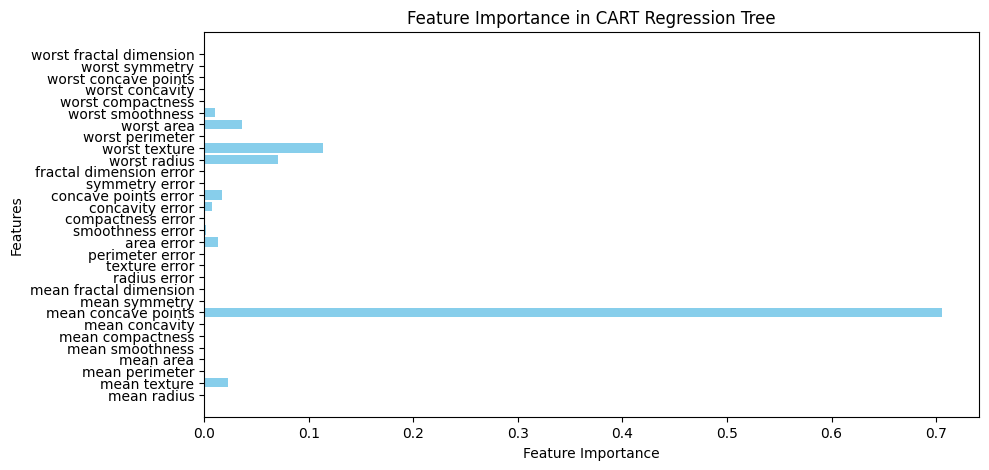

In [10]:

# Feature Importance Analysis
feature_importance = full_tree.feature_importances_
plt.figure(figsize=(10, 5))
plt.barh(data.feature_names, feature_importance, color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in CART Regression Tree")
plt.show()



## Tree pruning


In **R**, the `rpart` package provides automated pruning by selecting the **best complexity parameter (`cp`)** using **cross-validation**. In **Python (scikit-learn)** the equivalent is using **cost complexity pruning path** with or without **cross-validation**.





## Cost Complexity Pruning

We’ll use **Cost-Complexity Pruning** (a form of post-pruning) in scikit-learn. This method introduces a parameter $\alpha$ in a penalty term that grows with the number of leaf nodes.

$$
\text{Cost}_{\alpha}(T) = \text{MSE or Gini}(T) + \alpha \times |T|
$$

(For classification, we measure Gini or impurity-based metrics; $|T|$ is the number of leaves.)

A larger $\alpha$ prunes more aggressively. Typically, you generate a range of $\alpha$ values from the pruning path of a fully grown tree, then train multiple trees — each with a different $\alpha$ — and use cross-validation on the training set to pick the $\alpha$ that yields the best average performance.

Once the best $\alpha$
is found, you retrain a new tree on the entire training set with that
$\alpha$, and finally evaluate on the test set (which was held out from any model selection decisions).








Cost-Complexity Alphas found: [0.         0.00249033 0.00335008 0.00491483 0.00635319 0.0080402
 0.01072027 0.0143575  0.01623502 0.01716941 0.01852043 0.0281733
 0.33063959]


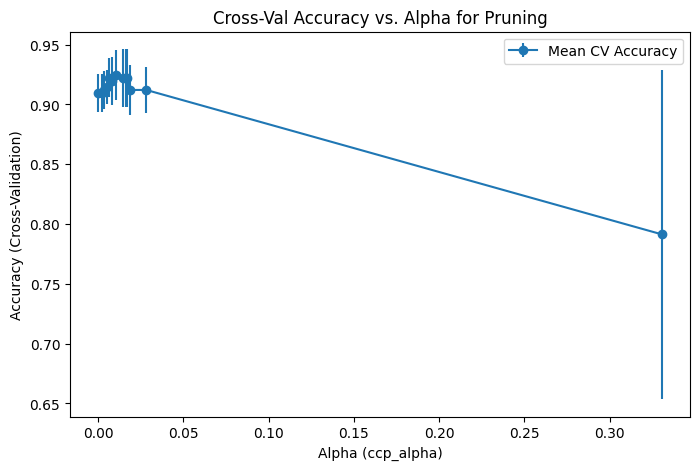


Chosen alpha = 0.0107, CV Accuracy = 0.9247

** Pruned Tree Performance **
Train Accuracy: 0.9698492462311558
Test Accuracy:  0.9590643274853801


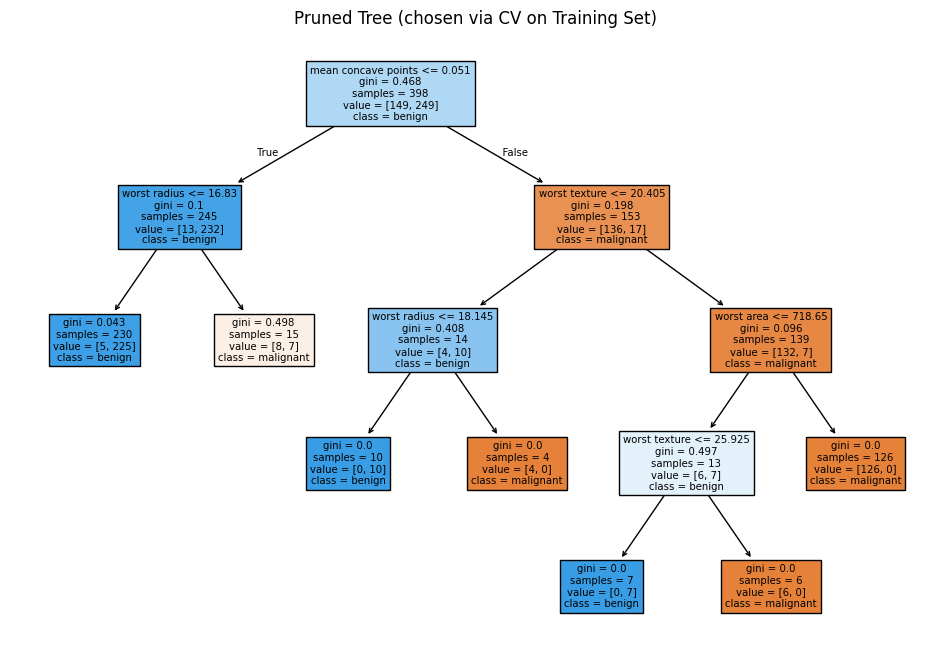

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score



# 4a) Obtain the cost-complexity pruning path from the *full* tree
path = full_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas  # array of alpha values
impurities = path.impurities

print("Cost-Complexity Alphas found:", ccp_alphas)

# 4b) For each alpha, train a new tree and get cross-validation accuracy
cv_mean_scores = []
cv_std_scores  = []

for alpha in ccp_alphas:
    dt_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    # Use cross-validation on the *training set* only
    scores = cross_val_score(dt_pruned, X_train, y_train, cv=5, scoring='accuracy')
    cv_mean_scores.append(scores.mean())
    cv_std_scores.append(scores.std())

# 5c) Plot alpha vs. average CV accuracy
plt.figure(figsize=(8,5))
plt.errorbar(ccp_alphas, cv_mean_scores, yerr=cv_std_scores, marker='o', label="Mean CV Accuracy")
plt.xlabel("Alpha (ccp_alpha)")
plt.ylabel("Accuracy (Cross-Validation)")
plt.title("Cross-Val Accuracy vs. Alpha for Pruning")
plt.legend()
plt.show()

# 5d) Select alpha that yields the best CV accuracy
idx_best = np.argmax(cv_mean_scores)
best_alpha = ccp_alphas[idx_best]
print(f"\nChosen alpha = {best_alpha:.4f}, CV Accuracy = {cv_mean_scores[idx_best]:.4f}")

# 5e) Retrain a pruned tree on the *entire training set* with best_alpha
pruned_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
pruned_tree.fit(X_train, y_train)

# Evaluate on the train set and the held-out test set
y_train_pred_pruned = pruned_tree.predict(X_train)
y_test_pred_pruned  = pruned_tree.predict(X_test)
train_acc_pruned = accuracy_score(y_train, y_train_pred_pruned)
test_acc_pruned  = accuracy_score(y_test,  y_test_pred_pruned)

print("\n** Pruned Tree Performance **")
print("Train Accuracy:", train_acc_pruned)
print("Test Accuracy: ", test_acc_pruned)

# Optional: Visualize the pruned tree
from sklearn.tree import plot_tree
plt.figure(figsize=(12,8))
plot_tree(
    pruned_tree,
    feature_names=data.feature_names,      # we still have 'data' from the initial load_breast_cancer()
    class_names=["malignant", "benign"],
    filled=True
)
plt.title("Pruned Tree (chosen via CV on Training Set)")
plt.show()


## Pruned vs. Full Tree Performance

It seems we were able to prevent overfitting using the pruning:

| Model       | Chosen Alpha | CV Accuracy | Train Accuracy | Test Accuracy |
|------------|-------------|-------------|---------------|--------------|
| Full Tree  | -           | -           | 1.0000        | 0.9415       |
| Pruned Tree | 0.0107      | 0.9247      | 0.9698        | **0.9591**       |


# Tree Methods Comparison
------------------

## CART (Classification and Regression Trees) $\leftarrow$ we just have seen that
CART is the base decision tree model used in machine learning. It builds a tree by:

- Splitting data at each node using a chosen criterion (e.g., Gini, entropy, RSS).
- Growing the tree until a stopping criterion is met.
- Optionally pruning the tree to prevent overfitting.

  
**Main advantage:** Highly interpretable.

**Main limitation:** A single CART tree can overfit and have high variance.

## Bootstrap Aggregation (Bagging)

Bagging reduces variance by averaging multiple trees.

**How it works:**
1. Train multiple **independent CART trees** on **bootstrap samples** of the dataset.
2. Aggregate predictions:
   - **Regression** $\rightarrow$ Take the **average** of all trees.
   - **Classification** $\rightarrow$ Use **majority voting**.

**Main advantage:** Reduces variance without increasing bias.

**Main limitation:** Trees are uncorrelated but still limited by CART weaknesses.




## Random Forests (Bagging + Feature Randomization) $\leftarrow$ we'll see it in a moment

Random forests improve bagging by **decorrelating trees**.

**How it works:**
1. Like **bagging**, but at each split, **only a random subset of features** is considered.
2. This **reduces correlation** between trees, leading to **better generalization**.

**Main advantage:** Even lower variance than bagging, **more robust**.

**Main limitation:** Still an **ensemble of weak learners**, doesn’t optimize trees cooperatively.



## Gradient Boosting $\leftarrow$ we'll see it next week

Gradient Boosting builds trees **sequentially**, each improving on the previous.

**How it works:**
1. Train a **CART tree** as the first weak model.
2. Compute **residual errors** (for regression) or **gradient of the loss function** (for classification).
3. Train the next tree to predict these **errors**, improving model performance.
4. Repeat, adding trees sequentially.

**Main advantage:** Stronger learners than bagging/random forests, handles complex patterns.

**Main limitation:** Slower training, can **overfit** without regularization.




## Summary: Key Differences

| Method             | Uses CART? | Trees are Independent? | Reduces Variance? | Reduces Bias? | Speed  |
|-------------------|------------|------------------|----------------|-------------|-------|
| **CART**          | ✅ Yes     | Not applicable           | Not applicable          | Not applicable        | Fast  |
| **Bagging**       | ✅ Yes     | ✅ Yes          | ✅ Yes         | ❌ No        | Medium |
| **Random Forest** | ✅ Yes     | ✅ Yes (less correlated) | ✅✅ Yes | ❌ No | Medium |
| **Gradient Boosting** | ✅ Yes | ❌ No (sequential) | ✅ Yes | ✅✅ Yes | Slow |

- **Random forests reduce variance by averaging many trees.**
- **Boosting methods iteratively reduce bias by correcting mistakes.**
- **Both can lead to lower bias and variance than a single model.**

# Random Forests
-----------------------

A Random Forest is an **ensemble** learning method that builds multiple decision trees on different random subsets of the training data, using also a randomized subset of features at each split. The two main forms of randomness are:

- **Bootstrap Sampling** of the data (if `bootstrap=True`), so each tree sees a sampled subset of the training set.
- Random selection of a **subset of features** at each node split (`max_features` parameter).

Each tree is typically grown to a certain maximum depth (or until leaf purity), then to predict a new instance, the forest combines (e.g., majority vote for classification) the predictions from each individual tree.

**Why does it work?** By averaging (or voting) across multiple de-correlated decision trees, Random Forests typically reduce the **variance of a single tree**, improving **generalization** and **robustness**. It often performs very well out-of-the-box on many classification and regression tasks.

## Implementation Notes

- `max_features='sqrt'`: At each split, the tree only considers $\sqrt{\text{total_features}}$ random features. This is a common default for classification.
- for regression, use $\frac{\text{total_features}}{3}$, passing `max_features=0.33`.

These are the default choices from `randomForest` package in R.

The default of `scikit learn` `RandomForestRegressor` is `max_features=1.0`. The note in their help file advices: ```default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3.```


Random Forest - Train Accuracy: 1.0
Random Forest - Test Accuracy: 0.9707602339181286
Random Forest - OOB Estimate Accuracy: 0.9547738693467337

Feature Importances:
mean radius: 0.0323
mean texture: 0.0111
mean perimeter: 0.0601
mean area: 0.0538
mean smoothness: 0.0062
mean compactness: 0.0092
mean concavity: 0.0806
mean concave points: 0.1419
mean symmetry: 0.0033
mean fractal dimension: 0.0031
radius error: 0.0164
texture error: 0.0032
perimeter error: 0.0118
area error: 0.0295
smoothness error: 0.0059
compactness error: 0.0046
concavity error: 0.0058
concave points error: 0.0034
symmetry error: 0.0040
fractal dimension error: 0.0071
worst radius: 0.0780
worst texture: 0.0188
worst perimeter: 0.0743
worst area: 0.1182
worst smoothness: 0.0118
worst compactness: 0.0175
worst concavity: 0.0411
worst concave points: 0.1271
worst symmetry: 0.0129
worst fractal dimension: 0.0069


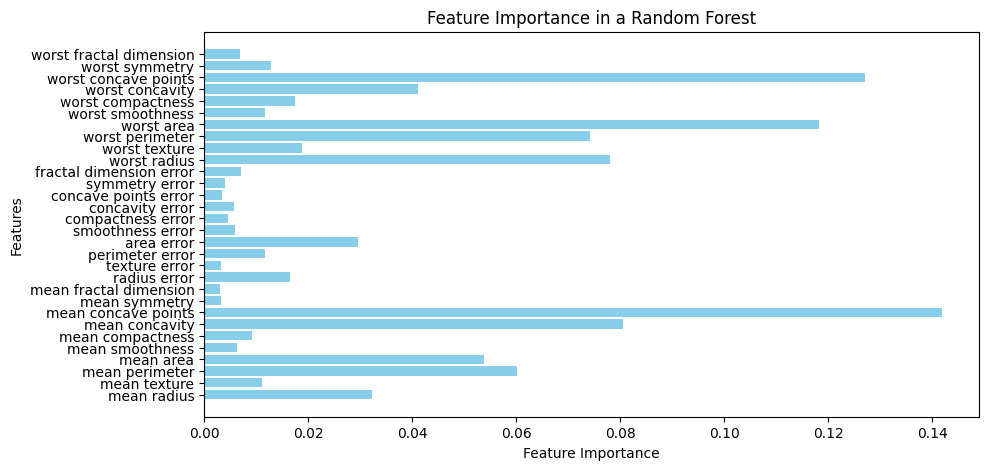

In [12]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# We assume X_train, X_test, y_train, y_test have already been defined,
# as in the previous CART examples.

# 1) Initialize the Random Forest
#    - n_estimators = number of trees
#    - random_state ensures reproducibility
rf = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    max_features='sqrt',  # typical default for classification
    random_state=42,
    oob_score=True  # Enable OOB estimation
)

# 2) Fit on training data
rf.fit(X_train, y_train)

# 3) Predict on train & test data
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

# 4) Evaluate
train_acc = accuracy_score(y_train, y_pred_train)
print("Random Forest - Train Accuracy:", train_acc)
test_acc = accuracy_score(y_test, y_pred_test)
print("Random Forest - Test Accuracy:", test_acc)

# 5) Compute and print OOB estimate
oob_score = rf.oob_score_
print("Random Forest - OOB Estimate Accuracy:", oob_score)

# 6) Inspect Feature Importances
feature_importance = rf.feature_importances_

# Print feature importances
print("\nFeature Importances:")
for name, importance in zip(data.feature_names, feature_importance):
    print(f"{name}: {importance:.4f}")

# Visualize feature importances
plt.figure(figsize=(10, 5))
plt.barh(data.feature_names, feature_importance, color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in a Random Forest")
plt.show()



## Tree Algorithms Performance

It seems we were able to prevent overfitting using pruning and Random Forests:

| Model       | Chosen Alpha | CV/OOB Accuracy | Train Accuracy | Test Accuracy |
|------------|-------------|-------------|---------------|--------------|
| Full CART Tree  | -           | -           | 1.0000        | 0.9415       |
| Pruned CART Tree | 0.0107      | 0.9247      | 0.9698        | 0.9591       |
| Random Forest | -      | 0.9548      | 1.0000        | **0.9708**       |

A single, unpruned decision tree can “memorize” its training set, so 100% training accuracy often indicates it has grown too complex (overfit).

In contrast, a random forest’s individual trees each may overfit their own bootstrap sample, but the averaging across many de-correlated trees acts like a built-in regularizer. Even though each tree might achieve near-perfect fit on its subset, their combined predictions typically generalize very well. Hence the random forest can have near-100% training accuracy yet maintain strong test performance, demonstrating it is not overfitting in the sense of failing to generalize.

# **Homework Assignment: Understanding Splitting Criteria in CART for Regression**
---------------------

In this assignment, you will explore three common formulations of the splitting criterion used in **CART (Classification and Regression Trees)** for **regression problems**:

1. **Local RSS Minimization**  
2. **RSS Gain Maximization**  
3. **Total RSS Minimization**

You will investigate whether any of these criteria are equivalent, and you will design an experiment to determine which criterion is actually employed in a standard implementation such as **scikit-learn’s DecisionTreeRegressor**.



## **The Problem**

Many treatments of CART for regression describe the split selection process in different ways. Below are three frequently cited formulations. Suppose we have a dataset with features $X$ and target $y$, and we seek to choose a feature $X_j$ and a threshold $t$ to split the data into two regions $R_1(X_j, t)$ and $R_2(X_j, t)$. Denote by $\bar{y}_{R_m}$ the mean of targets within region $R_m$.

1. **Local RSS Minimization**  
   We select the feature and threshold that minimize the **sum of squared errors** in the two resulting child nodes:
   $$
   (X_j^*, t^*) = \arg\min_{X_j, t} \sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2.
   $$

2. **RSS Gain Maximization**  

   It is also a local method, looking only at a parent and two child nodes.

   We select the feature and threshold that maximize the **reduction** in RSS, computed by subtracting the RSS of the two child nodes from the RSS in the parent node:
   $$
   (X_j^*, t^*) = \arg\max_{X_j, t} \Bigl\{
   \underbrace{\sum_{i : x_i \in \text{Parent}} (y_i - \bar{y})^2}_{\text{Parent RSS}}
   \;-\;
   \underbrace{\sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2}_{\text{Children RSS}}
   \Bigr\}.
   $$

3. **Total RSS Minimization**  
   For a dataset $\{(x_i, y_i)\}_{i=1}^N$ with features $X$ and target $y$, let $T$ be the current tree.

   For any split on feature $X_j$ at threshold $t$, define $T(X_j, t)$ as the new tree obtained by splitting one leaf of $T$ into two leaves $R_1(X_j, t)$ and $R_2(X_j, t)$.
   
   Let $\mathrm{Leaves}(T(X_j, t))$ be the set of all leaf indices in this new tree. For each leaf $m \in \mathrm{Leaves}(T(X_j, t))$, define:
   $$
   R_m = \{\, i \,\mid\, x_i \text{ ends in leaf } m\}.
   $$

   $R_m$ set collects all data indices $i$ whose feature vector $x_i$ is classified into the leaf node $m$ when passed through the tree $T(X_j,t)$. In other words, each leaf node $m$ in $T(X_j, t)$ corresponds to a unique path of splits, and any data point $x_i$ that follows that path is assigned to the leaf $m$; hence, it belongs to $R_m$.

   $R_m$ sets for all leafs $m \in \mathrm{Leaves}(T(X_j, t))$ define a partition of all indices.

   Then the objective of **minimizing total Residual Sum of Squares (total RSS)** is stated as:
   $$
   (X_j^*, t^*) = \arg\min_{(X_j, t)} \sum_{m \in \mathrm{Leaves}(T(X_j, t))}
   \sum_{i \in R_m} \Bigl(y_i - \overline{y}_{R_m}\Bigr)^2,
   $$
   where
   $$
   \overline{y}_{R_m} = \frac{1}{\lvert R_m \rvert}
   \sum_{i \in R_m} y_i
   $$
   is the mean response in leaf $m$.


## **Research Questions**

1. **Equivalence Analysis**  
   Determine whether the above formulations are equivalent or if they can yield different split choices. Specifically:
   - Are *local RSS minimization* and *RSS gain maximization* equivalent?
   - Does *total RSS minimization* coincide with either of these two, or is it distinct?
   
2. **Empirical Experiment**  
   Design and conduct a Python experiment to determine which of these formulations is implemented in `scikit-learn` in `DecisionTreeRegressor`. Present numerical results and plots to support your conclusion.


## **Tasks & Deliverables**

1. **Formulation Analysis**  
   - Compare *local RSS minimization*, *RSS gain maximization*, and *total RSS minimization*.
   - If you find that any pair of formulations is equivalent, provide a concise proof.  
   - If you find that they differ, construct a counterexample.

2. **Empirical Verification**  
   - Create a small artificial dataset and train a `DecisionTreeRegressor` from `scikit-learn`.
   - The dataset must be designed in a way that uniquely identifies the formulation used. Provide a short code snippet and a plot or table to support your conclusion.

3. **Report**  
   - Summarize your theoretical insights and empirical findings in a **Colab notebook**.
   - Include the relevant proofs, code, discussion, and conclusions.
   - Place the notebook in your **GitHub repository** for this course, add a link to it in your README.md and add an **“Open in Colab”** badge in the notebook so it can be launched directly.

